In [32]:
import numpy as np
from matplotlib import pyplot as plt

import requests # Reading from web source

# Machine learning
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift

In [33]:
# Cell to get the data
# Relevant informations can be found at https://user-web.icecube.wisc.edu/~grbweb_public/Variables.html

#-------------------------------------------------------
# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str', unpack='True')

print(data.shape)

# Read headers
with open("Summary_table.txt",'r') as f:
    names = np.array([n.strip().replace(" ", "_")
                      for n in f.readlines()[1].replace("#", "").replace("\n", "").lstrip().split('    ')
                      if n.strip() != ''])

# Make a dictionary using the headers and the data
data = dict(zip(names, data))

print(names)

(15, 8413)
['GRB_name' 'GRB_name_Fermi' 'T0' 'ra' 'decl' 'pos_error' 'T90'
 'T90_error' 'T90_start' 'fluence' 'fluence_error' 'redshift' "'T100'"
 'GBM_located' 'mjd_(T0)']


In [34]:
# Convert data from strings to floats
keys_to_convert = ['ra', 'decl', 'pos_error', 'T90', 'T90_error', 'fluence', 'fluence_error', 'redshift', "'T100'", 'mjd_(T0)']

for key in keys_to_convert:
    data[key] = np.array(data[key], dtype=float)

In [35]:
# Mask bad data points
bad_data_mask = (data['T90'] == -999) | (data['fluence'] == -999) | (data['fluence'] == 0)

for key in names:
    data[key] = data[key][~bad_data_mask]

print("Masked " + str(np.sum(bad_data_mask)) + " data points")
print("There are " + str(np.sum(~bad_data_mask)) + " data points left")

Masked 1176 data points
There are 7237 data points left


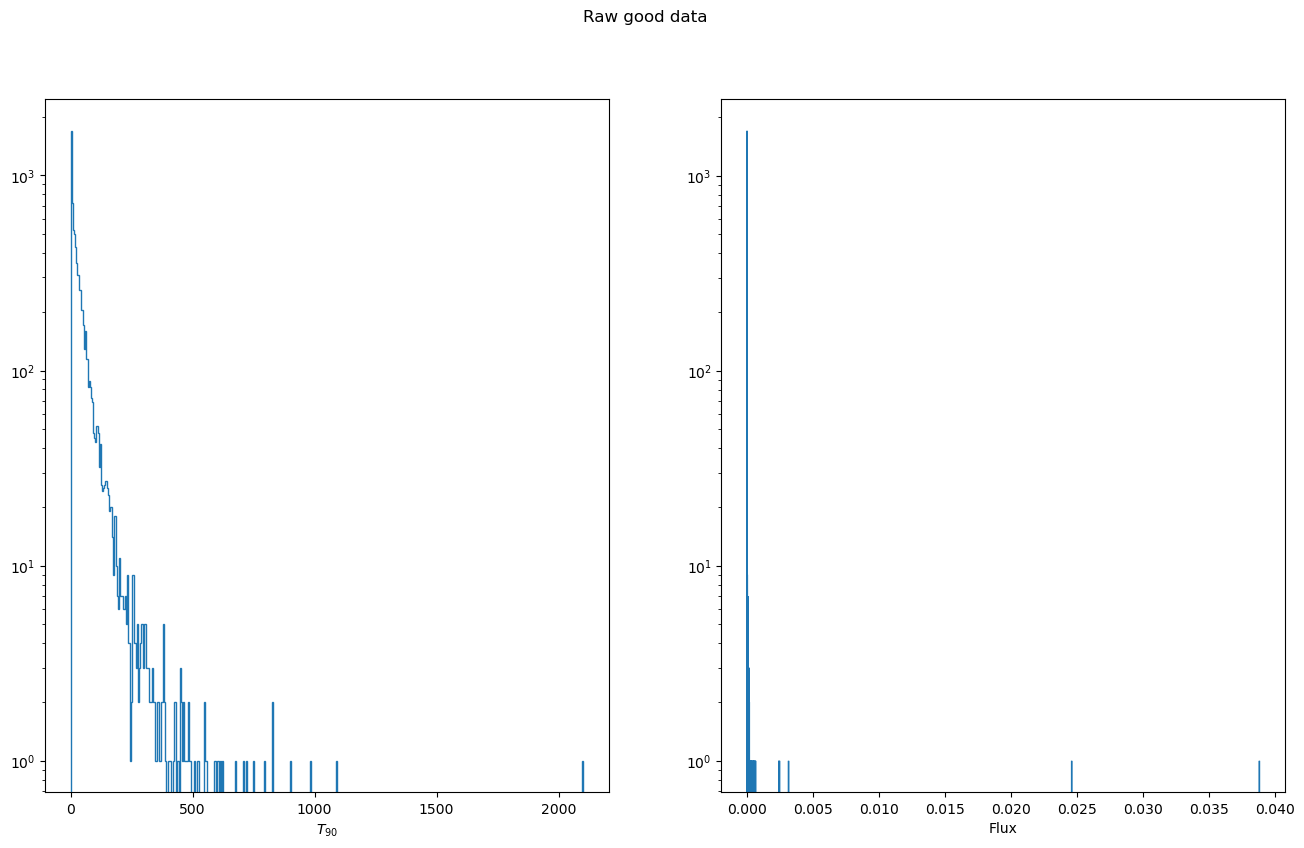

In [36]:
# Make a first plot of T90 and fluence
# Use log scale on y axis to see outliers
fig, ax = plt.subplots(1, 2, figsize=(16, 9))
fig.suptitle("Raw good data")

ax[0].set_xlabel(r'$T_{90}$')
ax[0].hist(data['T90'], bins='auto', histtype='step', density=False)
ax[0].set_yscale('log')

ax[1].set_xlabel('Flux')
ax[1].hist(data['fluence'], bins='auto', histtype='step', density=False)
ax[1].set_yscale('log')

plt.show()

In [37]:
# Decide where to truncate the data set with respect to T90 (exclude outliers)
T90_trunc = 300

bad_T90_mask = data['T90'] > T90_trunc

print("Mask covers " + str(np.sum(bad_T90_mask)) + " data points")

Mask covers 92 data points


In [38]:
# Decide where to truncate the data set with respect to fluence (exclude outliers)
fluence_trunc = 8e-5

bad_fluence_mask = data['fluence'] > fluence_trunc

print("Mask covers " + str(np.sum(bad_fluence_mask)) + " data points")

Mask covers 110 data points


In [39]:
# Combine the masks of bad data points
bad_data_mask = bad_T90_mask | bad_fluence_mask

print("Mask covers " + str(np.sum(bad_data_mask)) + " data points")

Mask covers 195 data points


# Mask the outliers

In [40]:
# Whether to mask the selected outliers or not
mask_bad_data = True

#-------------------------------------------
if mask_bad_data:
    # Mask the selected data
    for key in names:
        data[key] = data[key][~bad_data_mask]

    print("Masked " + str(np.sum(bad_data_mask)) + " data points")
    print("There are " + str(np.sum(~bad_data_mask)) + " data points left")

Masked 195 data points
There are 7042 data points left


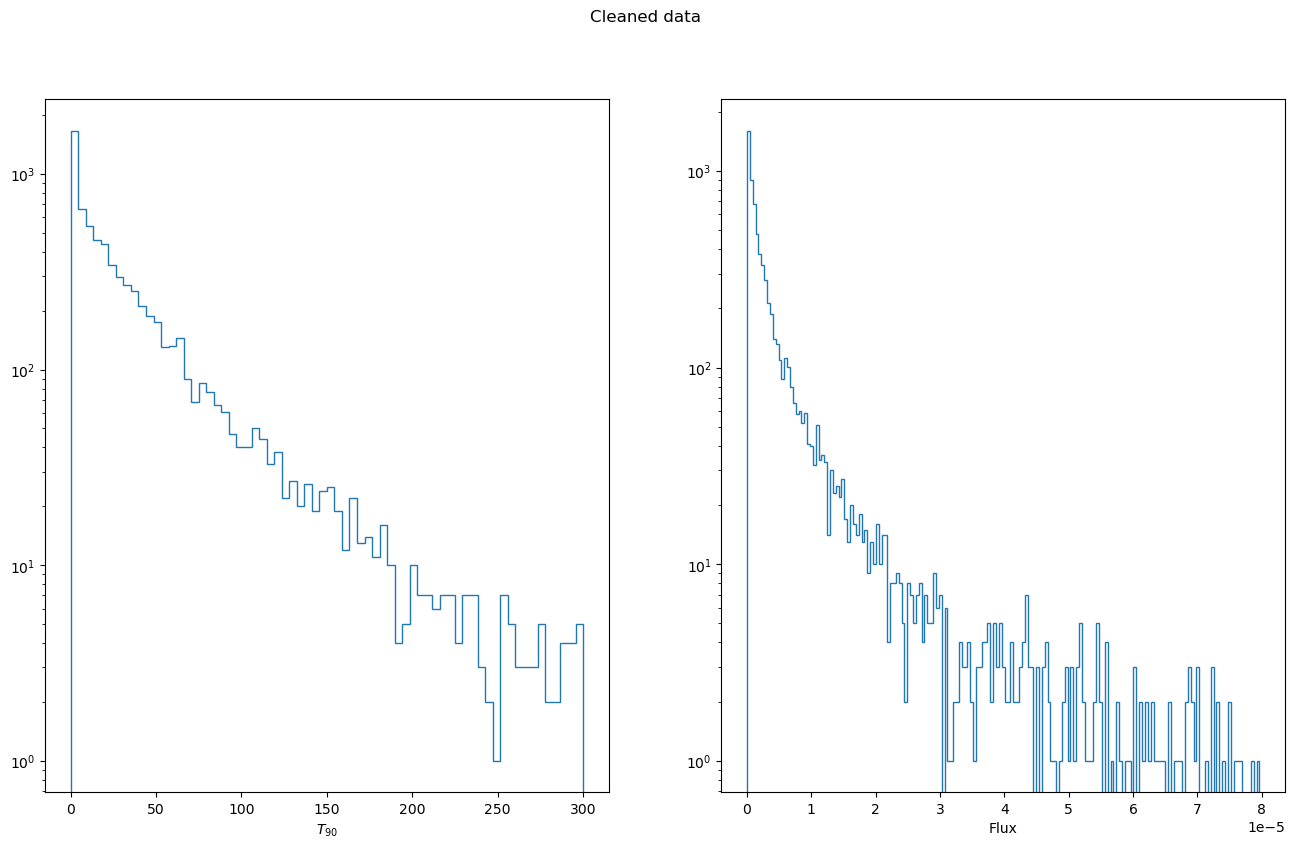

In [41]:
# Plot the cleaned data
fig, ax = plt.subplots(1, 2, figsize=(16, 9))
fig.suptitle("Cleaned data")

ax[0].set_xlabel(r'$T_{90}$')
ax[0].hist(data['T90'], bins='auto', histtype='step', density=False)
ax[0].set_yscale('log')

ax[1].set_xlabel('Flux')
ax[1].hist(data['fluence'], bins='auto', histtype='step', density=False)
ax[1].set_yscale('log')

plt.show()

# Just playing around with sklearn

In [42]:
# Wheter to run or not the KDE on the above histogram
play = True

In [43]:
if play:
    # Test 30 bandwidths from 0.1 to 1.0
    bw_range = np.linspace(0.01, 1.0, 40)
    print(bw_range)

    # Do K-fold cross validation
    K = 5 # 5 is the default value
    grid = GridSearchCV(KernelDensity(), {'bandwidth': bw_range}, cv=K)

    # Fit the grid search to the data
    grid.fit(data['T90'][:, np.newaxis])

    bw_opt = grid.best_params_['bandwidth']
    print(bw_opt)

[0.01       0.03538462 0.06076923 0.08615385 0.11153846 0.13692308
 0.16230769 0.18769231 0.21307692 0.23846154 0.26384615 0.28923077
 0.31461538 0.34       0.36538462 0.39076923 0.41615385 0.44153846
 0.46692308 0.49230769 0.51769231 0.54307692 0.56846154 0.59384615
 0.61923077 0.64461538 0.67       0.69538462 0.72076923 0.74615385
 0.77153846 0.79692308 0.82230769 0.84769231 0.87307692 0.89846154
 0.92384615 0.94923077 0.97461538 1.        ]
0.44153846153846155


In [44]:
def kde_sklearn(data, x_grid, bandwidth = 1.0):
    kde_skl = KernelDensity(bandwidth = bandwidth)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis]) # sklearn returns log(density)
    
    return np.exp(log_pdf)

In [45]:
if play:
    x_grid = np.linspace(-10, 300, 1000)
    T90_kde = kde_sklearn(data['T90'], x_grid, bandwidth=bw_opt)

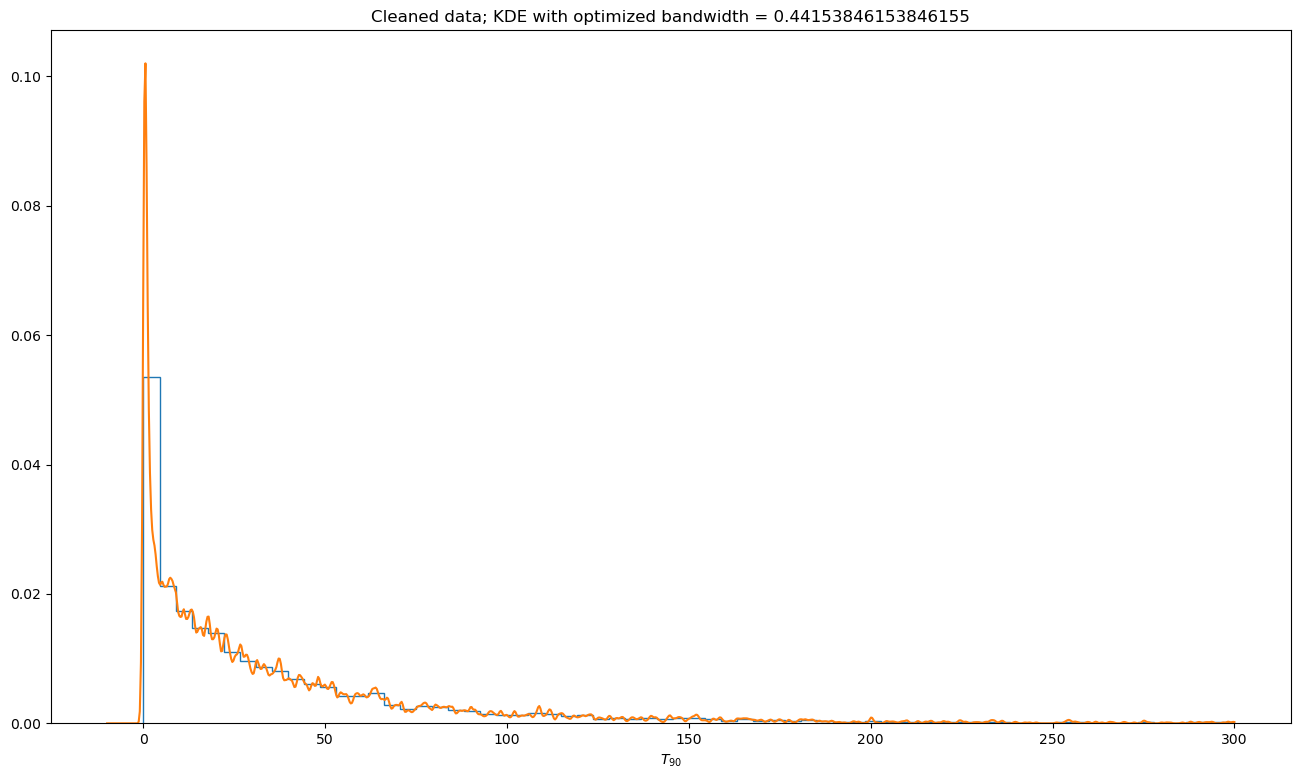

In [46]:
if play:
    fig, ax = plt.subplots(figsize=(16, 9))
    ax.set_title("Cleaned data; KDE with optimized bandwidth = " + str(bw_opt))
    ax.set_xlabel(r'$T_{90}$')

    ax.hist(data['T90'], bins='auto', histtype='step', density=True)
    ax.plot(x_grid, T90_kde)

    plt.show()

# Playing stop

# Flux vs $T_{90}$

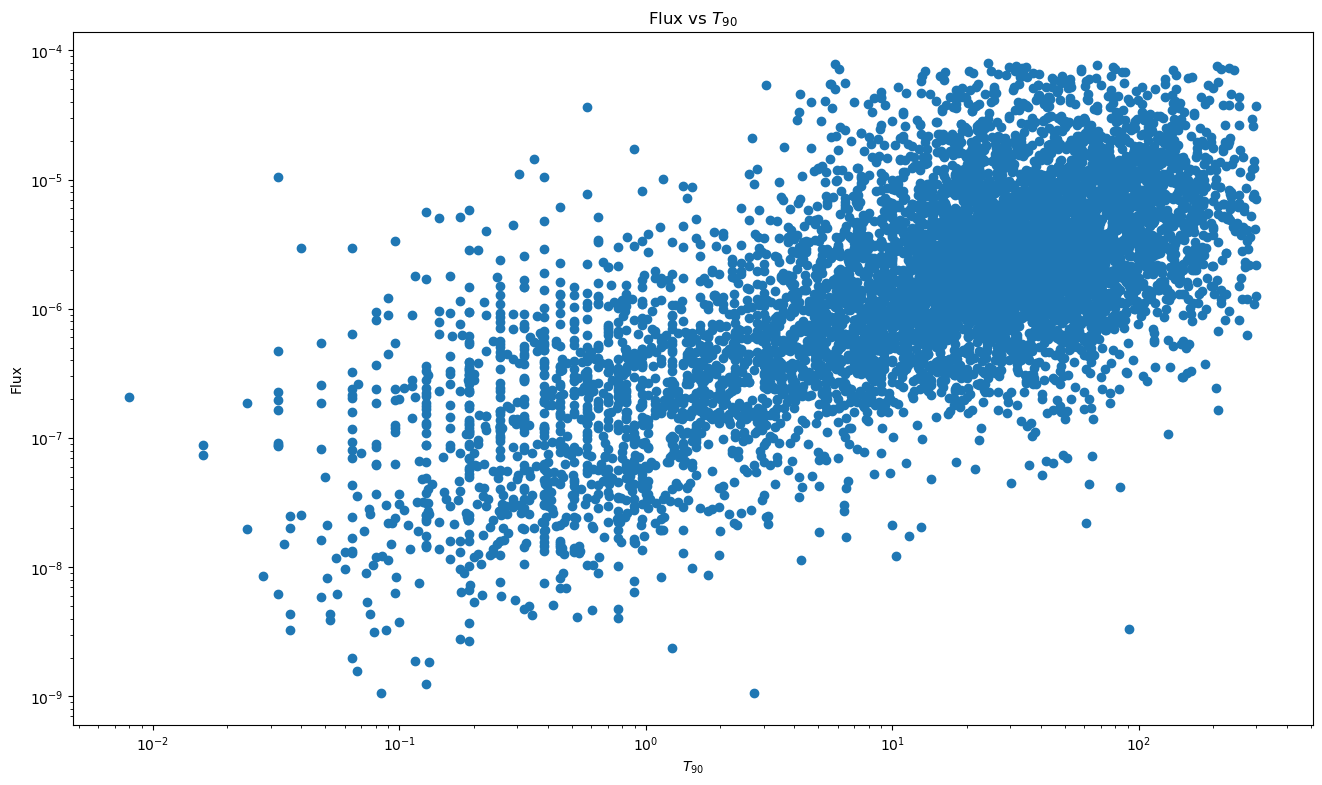

In [47]:
# Plot fluence vs T90
fig, ax = plt.subplots(figsize=(16, 9))
ax.set_title(r"Flux vs $T_{90}$")
ax.set_xlabel(r'$T_{90}$')
ax.set_ylabel('Flux')

ax.scatter(data['T90'], data['fluence'])

ax.set_yscale('log')
ax.set_xscale('log')

plt.show()

In [48]:
# Merge the plotted data in the shape scikit-learn wants
# Note that we are using the log of the data since that's what we plotted above
sklearn_data = np.stack([np.log10(data['T90']), np.log10(data['fluence'])], axis=1)

# **KMeans**

Searching for 2 clusters.

In [49]:
# Initialise a KMeans object for clustering estimation
n_clusters = 2
clf = KMeans(n_clusters=n_clusters, n_init='auto')

# Fit to the data
clf.fit(sklearn_data)

KMeans(n_clusters=2)

In [50]:
# Get the cluster each point belong to
labels_KM = clf.predict(sklearn_data)

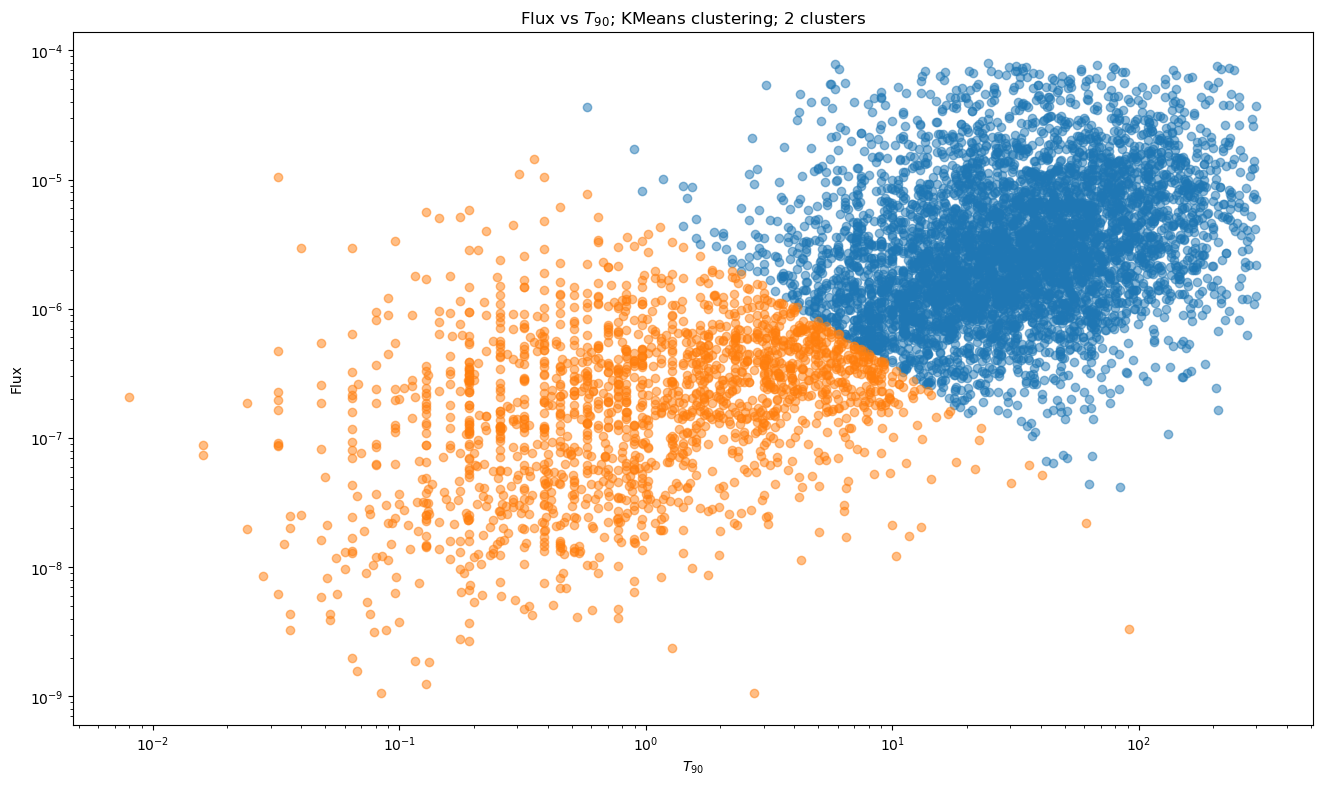

In [51]:
# Plot the data using the predicted labels
fig, ax = plt.subplots(figsize=(16, 9))
ax.set_title(r"Flux vs $T_{90}$; KMeans clustering; " + str(len(clf.cluster_centers_)) + " clusters")
ax.set_xlabel(r'$T_{90}$')
ax.set_ylabel('Flux')

for i in range(len(clf.cluster_centers_)):
    ax.scatter(data['T90'][labels_KM == i], data['fluence'][labels_KM == i], alpha=0.5)

ax.set_xscale('log')
ax.set_yscale('log')

plt.show()

# **MeanShift**

The choice of the bandwith highly impacts the result of the algorithm. MeanShift is also sensitive to outliers. Try the clustering with and without masking the outliers. See the first part of the notebook for data masking.

In [52]:
# Initialise a MeanShift object for clustering estimation
# The bandwith is optional; MeanShift will figure out by its self what bandwith
# to use if no bandwith is given
bandwidth = 0.5 # 0.5 shows some multi-modality in fluence vs T90
ms = MeanShift(bin_seeding=True, cluster_all=False, bandwidth=bandwidth)

# Fit to the data
ms.fit(sklearn_data)

MeanShift(bandwidth=0.5, bin_seeding=True, cluster_all=False)

In [53]:
# Get the cluster each point belong to
labels_MS = ms.predict(sklearn_data)

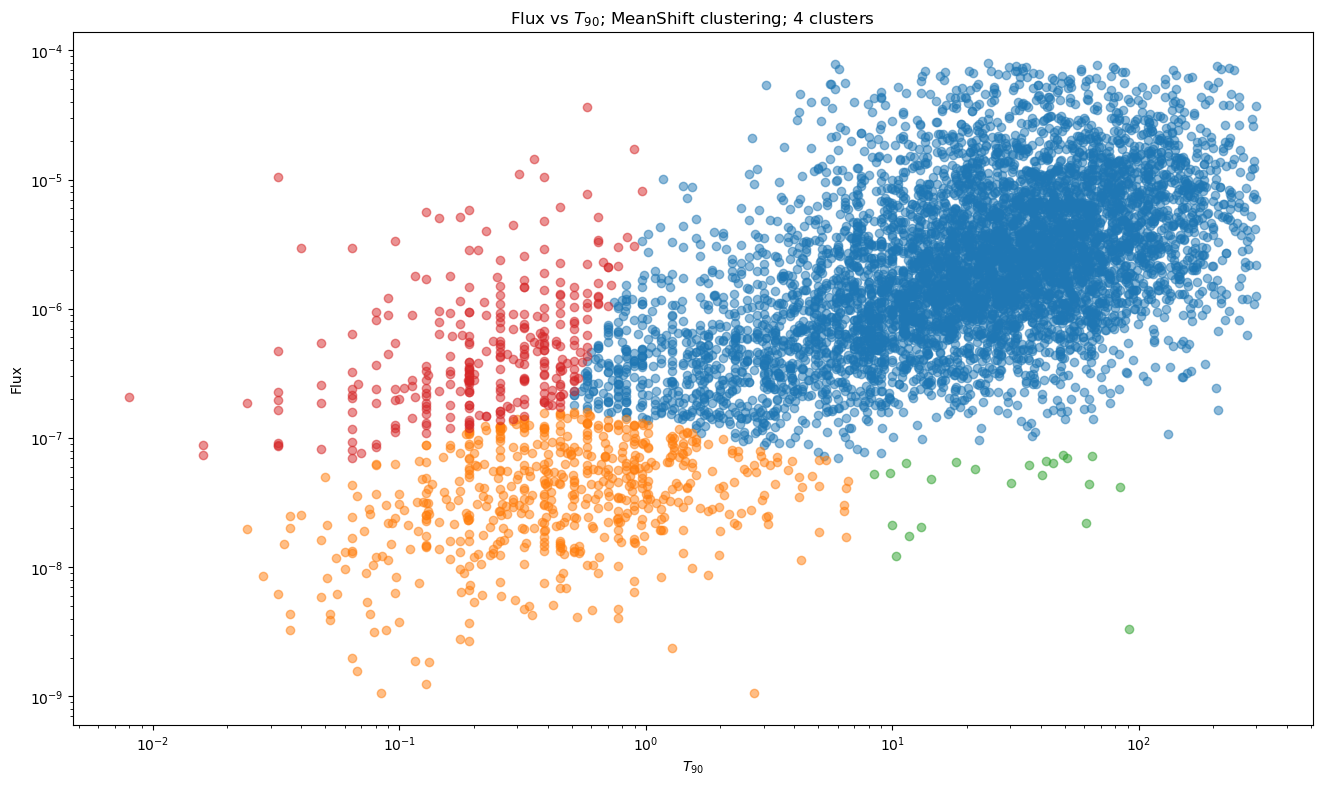

In [54]:
# Plot the data using the predicted labels
fig, ax = plt.subplots(figsize=(16, 9))
ax.set_title(r"Flux vs $T_{90}$; MeanShift clustering; " + str(len(ms.cluster_centers_)) + " clusters")
ax.set_xlabel(r'$T_{90}$')
ax.set_ylabel('Flux')

for i in range(len(ms.cluster_centers_)):
    ax.scatter(data['T90'][labels_MS == i], data['fluence'][labels_MS == i], alpha=0.5)

ax.set_xscale('log')
ax.set_yscale('log')

plt.show()